## Подгружаем все

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import seaborn as sns
sns.set(font_scale=1.3, style='whitegrid', palette='Set2')

import numpy as np
from IPython import display

import copy
import random
import time

import math
from tqdm.notebook import tqdm

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
%ls
%cd 'gdrive/MyDrive/mipt-opt/hw8'

gdrive/  sample_data/
/content/gdrive/MyDrive/mipt-opt/hw8


In [29]:
%%shell
jupyter nbconvert --to html mipt-opt-hw8.ipynb

[NbConvertApp] Converting notebook mipt-opt-hw8.ipynb to html
[NbConvertApp] Writing 3776518 bytes to mipt-opt-hw8.html


Это игрушечно -исследовательское задание
Перед Вами задача бинарной классификации. Как модель мы будем использывать двуслойный перцептрон.
Изучите, как отрабатывают различные оптимизаторы на этой задаче. Обязательно попробовать  Adam, RMSProp, SGD, L-BFGS. Другие тоже можно

Сделать выводы по полученным результатам.

In [5]:
# Cтроим простой перцептрончик: Один линейный слой потом Релу (что это такое, кстати?=)), еще линейный слой и сигмоиду, которая будет выдавать вероятности классов
# hidden size можно варьировать. input_size - кол-во признаков в объекте

class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size

        self.linear1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.linear1(x)
        relu = self.relu(hidden)
        output = self.linear2(relu)
        output = self.sigmoid(output)
        return output

$ReLU(x) = max(x, 0)$

## Готовимся


In [6]:
class NaiveBatchGen:
    def __init__(self, X, y, batch_size):
        if X.shape[0] != y.shape[0]:
            raise ValueError("Incorrect sizes of X and y")
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.cnt = 0
        self.size = X.shape[0]
        self.permutation = torch.randperm(self.size)

    def size(self):
        return math.ceil(self.size / self.batch_size)

    def __iter__(self):
        return self

    def __next__(self):
        if self.cnt >= self.size:
            raise StopIteration
        indices = self.permutation[self.cnt : self.cnt + self.batch_size]
        self.cnt += self.batch_size
        return self.X[indices], self.y[indices]

In [7]:
def my_train(model, X, y, optimizer, criterion, batch_size, lbfgs=False):
    loss_array = []
    model.train()
    if not lbfgs:
        for batch_x, batch_y in NaiveBatchGen(X, y, batch_size):
            # Считаем лосс и добавляем его значение в массив
            optimizer.zero_grad()
            
            outputs = model.forward(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()

            loss_array.append(loss.item())
    else:
        for batch_x, batch_y in NaiveBatchGen(X, y, batch_size):
            # Считаем лосс и добавляем его значение в массив
            def closure():
                optimizer.zero_grad()
                outputs = model.forward(batch_x)
                loss = criterion(outputs.squeeze(), batch_y)
                loss.backward()
                return loss
        
            loss = optimizer.step(closure)
            loss_array.append(loss.item())
       
    return loss_array, model
    
def my_test(model, X, y, optimizer, criterion, batch_size, lbfgs=False):
    loss_test_array = []
    model.eval()
    for batch_x, batch_y in NaiveBatchGen(X, y, batch_size):
        outputs = model.forward(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        loss_test_array.append(loss.item())

    return loss_test_array

In [8]:
def setup_data(n_samples=500, n_features=20):
    # Делаем рандомную задачу бинарной классификации. По умолчанию make_classification порождает объект с 20 признаками. 
    # Это значение можно варьировать. И его надо подавать как input_size в модель
    X, Y = make_classification(n_samples=n_samples, n_features=n_features)

    # Делим выборку на обучающую и тестовую
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # перегоняем все в торч
    x_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)

    x_test = torch.FloatTensor(X_test)
    y_test = torch.FloatTensor(y_test)
    
    return x_train, y_train, x_test, y_test

def setup_model(input_size=20, hidden_size=10):
    # модель
    return MLP(input_size, hidden_size)

In [9]:
x_train, y_train, x_test, y_test = setup_data(n_samples=1000, n_features=50)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 50]),
 torch.Size([200, 50]),
 torch.Size([800]),
 torch.Size([200]))

In [10]:
# Критерий/ функция потерь
criterion = torch.nn.BCELoss()
model = setup_model(input_size=50, hidden_size=10)
model

MLP(
  (linear1): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [18]:
import collections

def test_optimizer_lbfgs(Optimizer, lr=1e-4, history_size=400, max_iter=400, n_epochs=100, n_exp=1, batch_size=50,
                         train_line_fmt=dict(), test_line_fmt=dict(), clear_display=True, figsz=None):
    # Optimizer should be an instance of LBFGS
    optimizer_name = 'LBFGS'
    if not isinstance(history_size, (collections.Sequence, np.ndarray)):
        history_sizes = [history_size]
    else:
        history_sizes = history_size
    
    if not isinstance(max_iter, (collections.Sequence, np.ndarray)):
        max_iters = [max_iter]
    else:
        max_iters = max_iter

    if clear_display:
        display.clear_output(wait=True)

    if figsz is None:
        figsz = (16 + (len(max_iters) - 1) * 4, 10 + (len(history_sizes) - 1) * 3)

    fig, axs = plt.subplots(len(history_sizes), len(max_iters), figsize=figsz)

    if len(history_sizes) == 1 and len(max_iters) == 1:
        axs = np.array([[axs]])
    elif len(history_sizes) == 1:
        axs = axs[np.newaxis, :]
    elif len(max_iters) == 1:
        axs = axs[:, np.newaxis]
    
    if len(axs) >= 3:
        fig.suptitle('Сравнение кривых обучения при разных гиперпараметрах ' + optimizer_name, fontsize=20)

    with tqdm(total=n_exp*n_epochs*len(history_sizes)*len(max_iters)) as pbar:
        for i, history_size in enumerate(history_sizes):
            for j, max_iter in enumerate(max_iters):
                ax = axs[i, j]
                for _ in range(n_exp):
                    x_train, y_train, x_test, y_test= setup_data()
                    model = setup_model()
                    optimizer = Optimizer(model.parameters(), lr=lr, max_iter=max_iter, history_size=history_size)

                    epoch_array = []
                    epoch_test_array = []

                    for epoch in range(n_epochs):
                        loss_array, a = my_train(model, x_train, y_train, optimizer, criterion, batch_size, lbfgs=True)
                        loss_test_array = my_test(model, x_test, y_test, optimizer, criterion, batch_size, lbfgs=True)

                        # усредняем лосс на обучении и тесте по эпохе и выводим график
                        epoch_array.append(np.mean(loss_array))
                        epoch_test_array.append(np.mean(loss_test_array))
                        pbar.update(1)

                    # display.clear_output(wait=True)
                    ax.plot(epoch_array, **train_line_fmt)
                    ax.plot(epoch_test_array, **test_line_fmt)

                # plt.legend(loc="best", fontsize=20)
                train_legend = mlines.Line2D([0], [0], **train_line_fmt, label='Train')
                test_legend = mlines.Line2D([0], [0], **test_line_fmt, label='Test')
                ax.set_ylim([0, 1])
                ax.legend(handles=[train_legend, test_legend], fontsize=18)
                ax.set_title("Случай " + optimizer_name + f"\n с max_iter={max_iter} и размером history_size={history_size}")

    fig.subplots_adjust(top=0.90, hspace=0.31)
    plt.show()


def test_optimizer(Optimizer, lr=1e-3, params=dict(), n_epochs=100, batch_size=50, n_exp=1, train_line_fmt=dict(),
                   test_line_fmt=dict(), lbfgs=False, clear_display=True, optimizer_name=None, figsz=None):
    if lbfgs:
        test_optimizer_lbfgs(Optimizer=Optimizer, lr=lr, n_epochs=n_epochs, batch_size=batch_size, train_line_fmt=train_line_fmt,
                             test_line_fmt=test_line_fmt, clear_display=clear_display, n_exp=n_exp, **params, figsz=figsz)
        return
    if optimizer_name is None:
        optimizer_name = Optimizer.__name__
    if not isinstance(batch_size, (collections.Sequence, np.ndarray)):
        batch_sizes = [batch_size]
    else:
        batch_sizes = batch_size
    
    if not isinstance(lr, (collections.Sequence, np.ndarray)):
        lrs = [lr]
    else:
        lrs = lr

    if clear_display:
        display.clear_output(wait=True)

    if figsz is None:
        figsz = (16 + (len(batch_sizes) - 1) * 4, 10 + (len(lrs) - 1) * 3)
    fig, axs = plt.subplots(len(lrs), len(batch_sizes), figsize=figsz)

    if len(lrs) == 1 and len(batch_sizes) == 1:
        axs = np.array([[axs]])
    elif len(lrs) == 1:
        axs = axs[np.newaxis, :]
    elif len(batch_sizes) == 1:
        axs = axs[:, np.newaxis]
    
    if len(axs) >= 3:
        fig.suptitle('Сравнение кривых обучения при разных гиперпараметрах', fontsize=20)

    with tqdm(total=n_exp*n_epochs*len(lrs)*len(batch_sizes)) as pbar:
        for i, lr in enumerate(lrs):
            for j, batch_size in enumerate(batch_sizes):
                ax = axs[i, j]
                for _ in range(n_exp):
                    x_train, y_train, x_test, y_test= setup_data()
                    model = setup_model()
                    optimizer = Optimizer(model.parameters(), lr=lr, **params)

                    epoch_array = []
                    epoch_test_array = []

                    for epoch in range(n_epochs):
                        loss_array, a = my_train(model, x_train, y_train, optimizer, criterion, batch_size=batch_size, lbfgs=lbfgs)
                        loss_test_array = my_test(model, x_test, y_test, optimizer, criterion, batch_size=batch_size, lbfgs=lbfgs)

                        # усредняем лосс на обучении и тесте по эпохе и выводим график
                        epoch_array.append(np.mean(loss_array))
                        epoch_test_array.append(np.mean(loss_test_array))
                        pbar.update(1)

                    # display.clear_output(wait=True)
                    ax.plot(epoch_array, **train_line_fmt)
                    ax.plot(epoch_test_array, **test_line_fmt)

                # plt.legend(loc="best", fontsize=20)
                train_legend = mlines.Line2D([0], [0], **train_line_fmt, label='Train')
                test_legend = mlines.Line2D([0], [0], **test_line_fmt, label='Test')
                ax.set_ylim([0, 1])
                ax.legend(handles=[train_legend, test_legend], fontsize=18)
                ax.set_title("Случай " + optimizer_name + f"\n с lr={lr} и размером batch-ей {batch_size}")

    fig.subplots_adjust(top=0.90, hspace=0.31)
    plt.show()

## Смотрим методы

### SGD

  0%|          | 0/63000 [00:00<?, ?it/s]

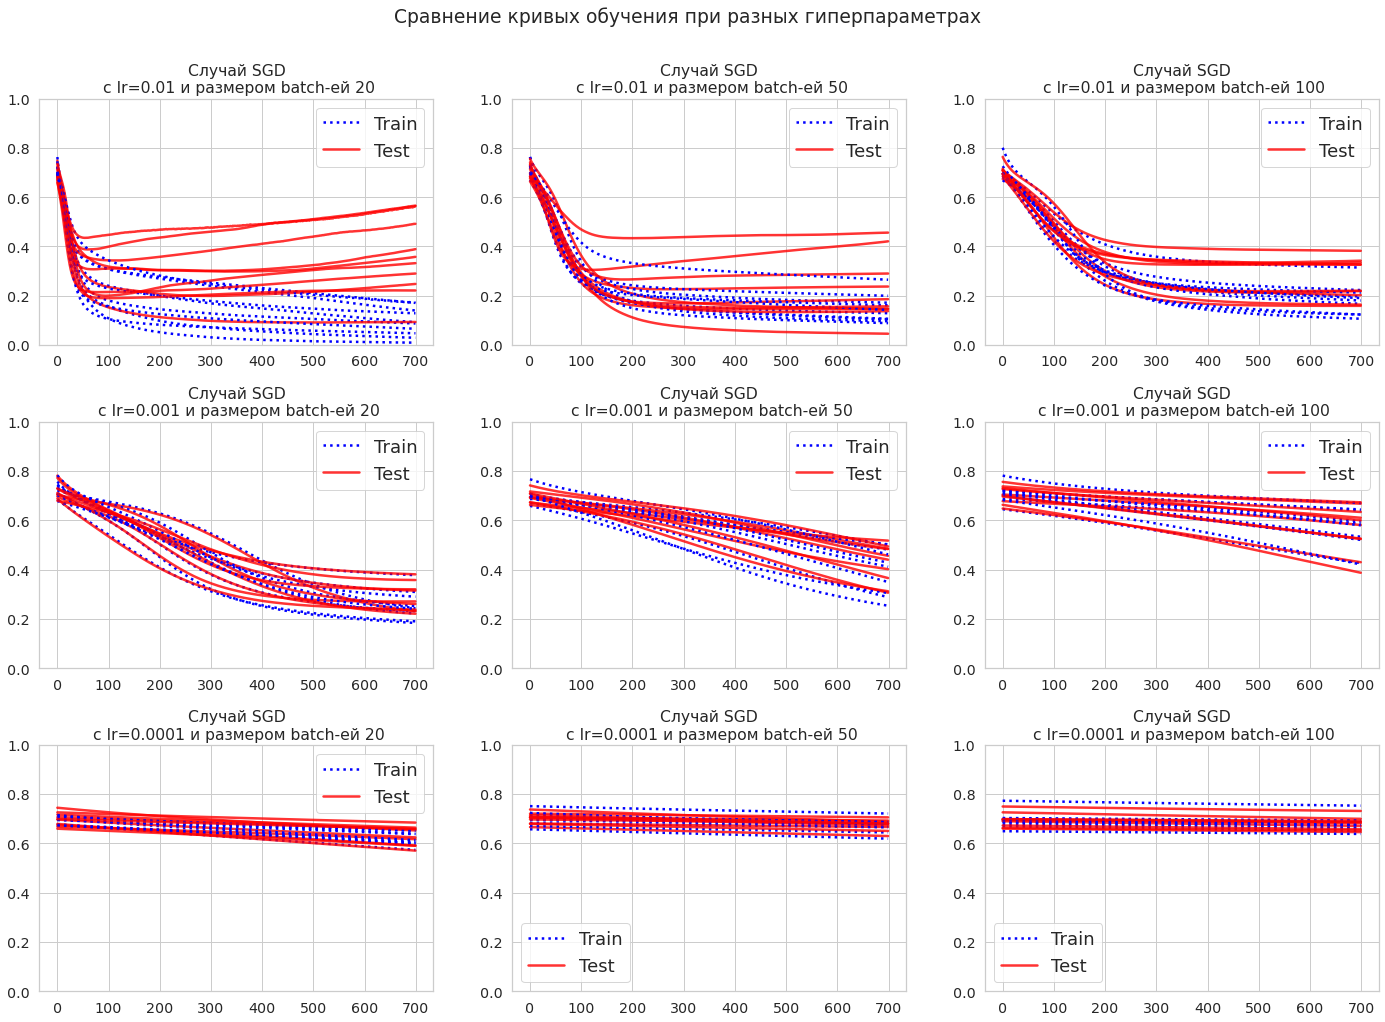

In [ ]:
test_optimizer(
    optim.SGD,
    lr=[1e-2, 1e-3, 1e-4],
    params={},
    n_epochs=700,
    batch_size=[20, 50, 100],
    n_exp=10,
    train_line_fmt={'linewidth':2.5, 'color':'b', 'ls':'dotted', 'alpha':1},
    test_line_fmt={'linewidth':2.5, 'color':'r', 'alpha':0.8}
)

**ВЫВОД:**

SGD в данном случае нужно достаточно точно выдавать гиперпараметры - он начинает немного переобучать модель, если lr большой и batch_size - маленький. С другой стороны, он в целом не слишком сильно переобучается, и в остальных случаях достаточно стабильно сходится к среднему значению Loss-a на TEST около 0.2 - 0.4

### SGD Momentum

  0%|          | 0/63000 [00:00<?, ?it/s]

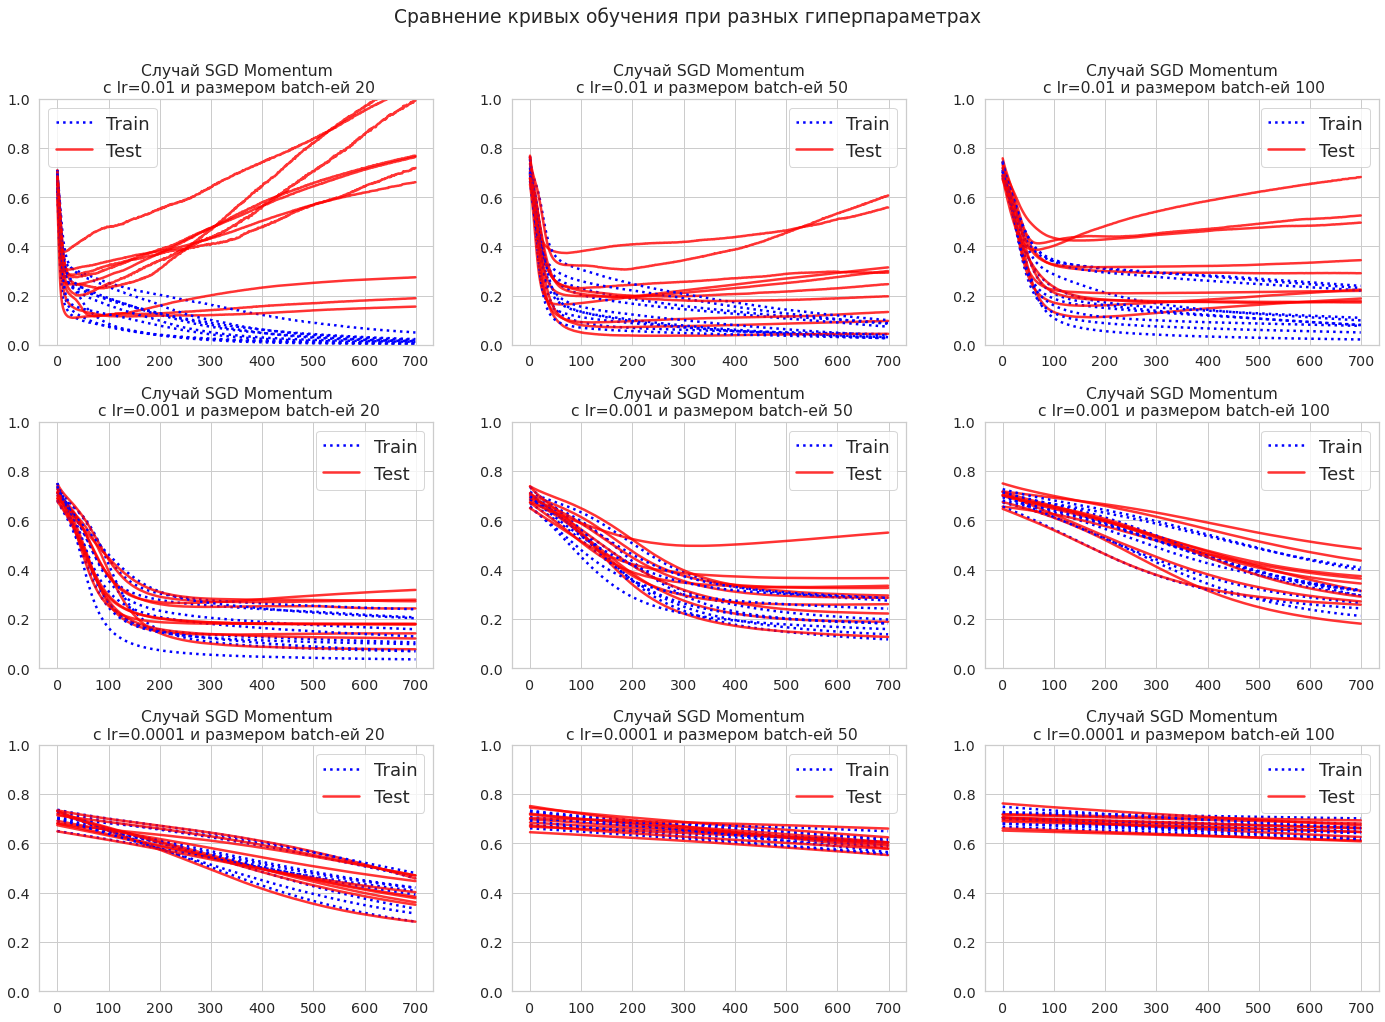

In [ ]:
test_optimizer(
    optim.SGD,
    lr=[1e-2, 1e-3, 1e-4],
    params={"momentum":0.7},
    n_epochs=700,
    batch_size=[20, 50, 100],
    n_exp=10,
    train_line_fmt={'linewidth':2.5, 'color':'b', 'ls':'dotted', 'alpha':1},
    test_line_fmt={'linewidth':2.5, 'color':'r', 'alpha':0.8},
    optimizer_name='SGD Momentum'
)

**ВЫВОД:**

SGD-Momentum обучается лучше обычного SGD, хотя и чуть менее стабильно - у него случаи с переобучением случаются чаще. При этом, может давать при правильных гиперпараметрах ($lr = 0.001; \:\:batch\_size = 20$) среднее значение Loss-a на TEST около 0.15 - 0.35



### Adagrad

  0%|          | 0/63000 [00:00<?, ?it/s]

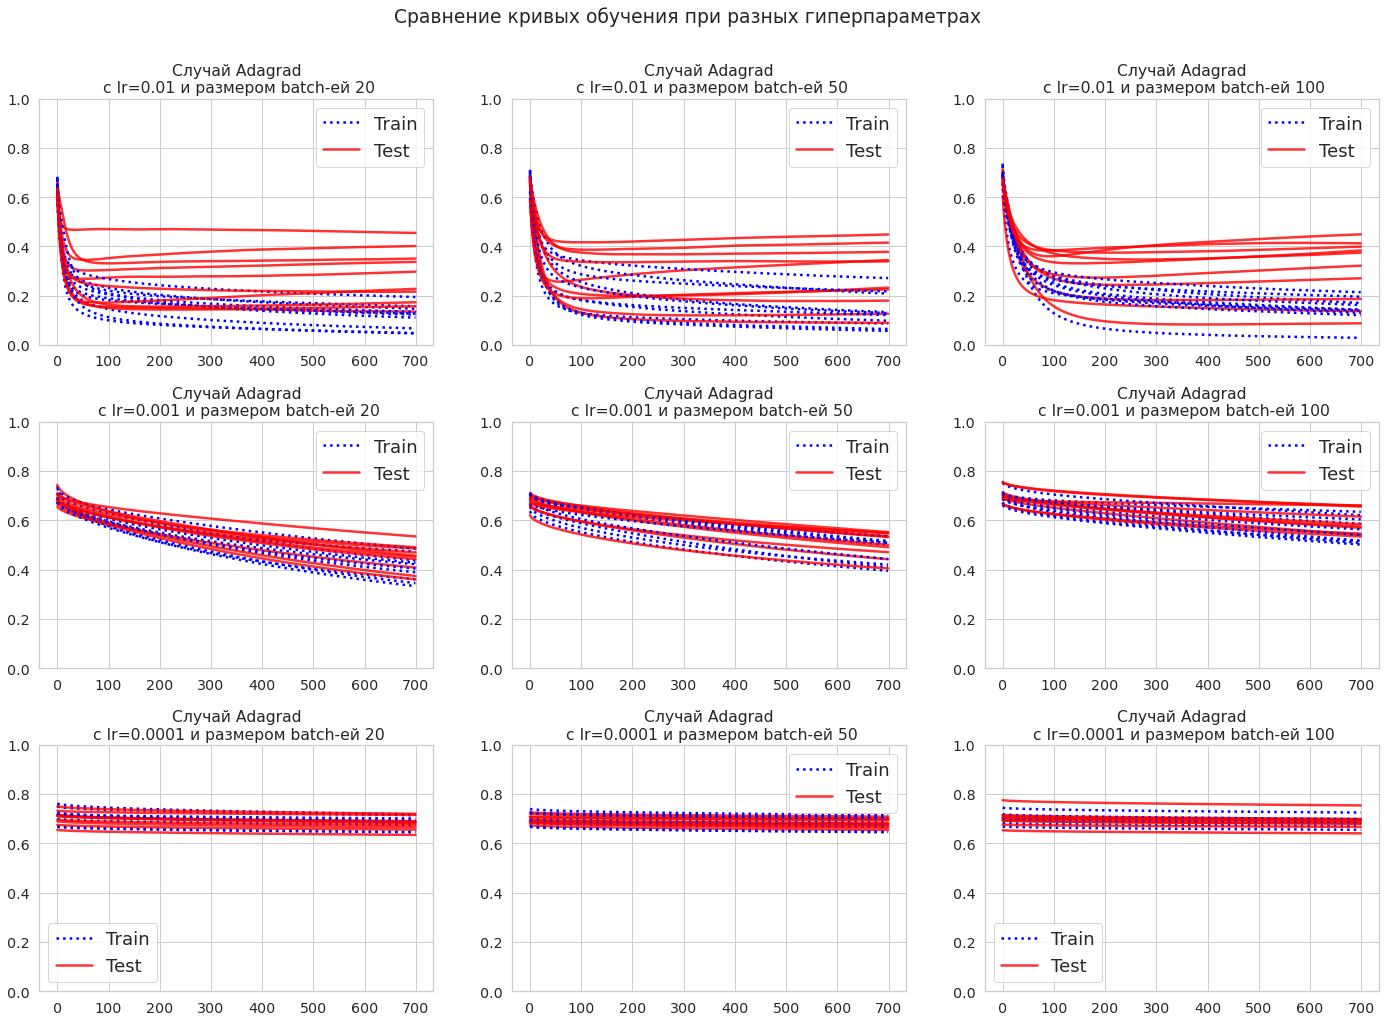

In [ ]:
test_optimizer(
    optim.Adagrad,
    lr=[1e-2, 1e-3, 1e-4],
    n_epochs=700,
    batch_size=[20, 50, 100],
    n_exp=10,
    train_line_fmt={'linewidth':2.5, 'color':'b', 'ls':'dotted', 'alpha':1},
    test_line_fmt={'linewidth':2.5, 'color':'r', 'alpha':0.8}
)

**ВЫВОД:**

Adagrad - быстрая машинка, которой нужен хороший lr, ибо на маленьких значений он начинает очень плохо учиться. При этом с правильными параметрами ($lr = 0.01; \:\:batch\_size = 50\;|\;100$) дает всего за 100 шагов уровень Loss-a на TEST около 0.20 - 0.40



### RMSprop

  0%|          | 0/63000 [00:00<?, ?it/s]

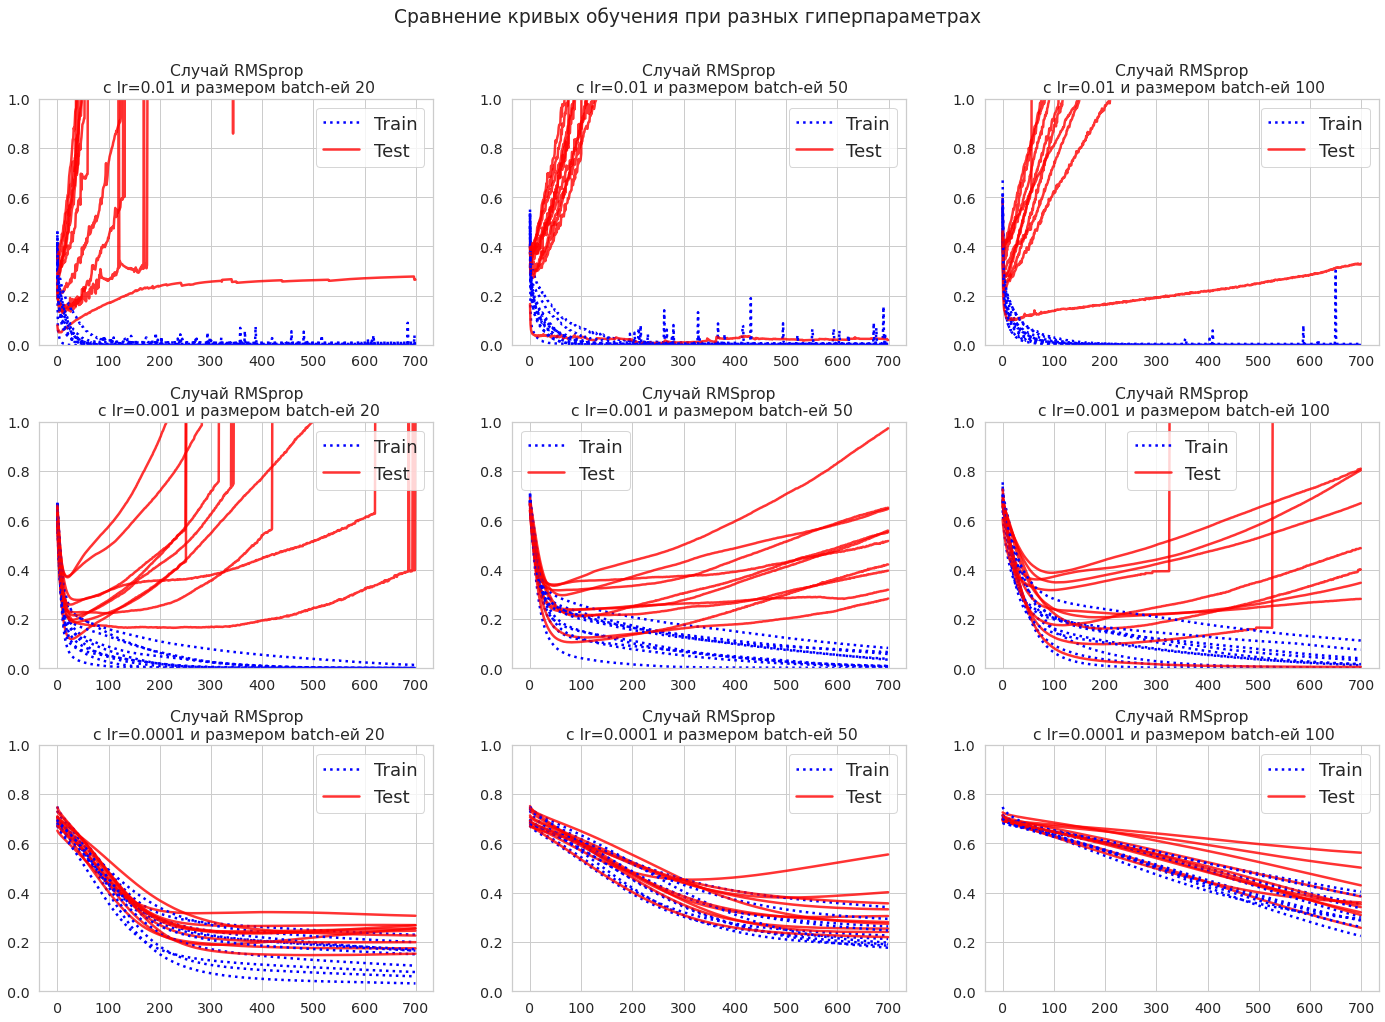

In [ ]:
test_optimizer(
    optim.RMSprop,
    lr=[1e-2, 1e-3, 1e-4],
    n_epochs=700,
    batch_size=[20, 50, 100],
    n_exp=10,
    train_line_fmt={'linewidth':2.5, 'color':'b', 'ls':'dotted', 'alpha':1},
    test_line_fmt={'linewidth':2.5, 'color':'r', 'alpha':0.8}
)

  0%|          | 0/2000 [00:00<?, ?it/s]

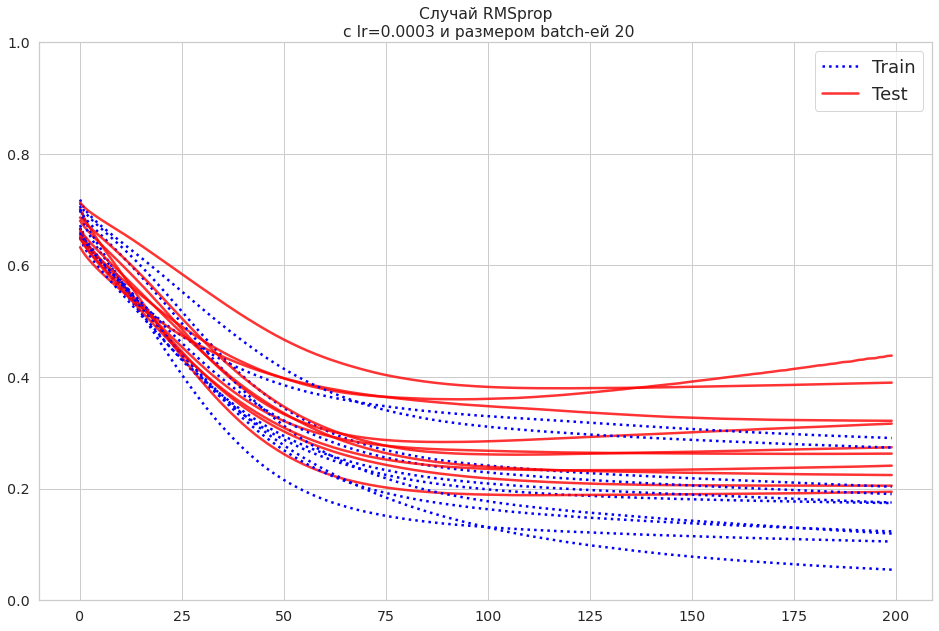

In [ ]:
test_optimizer(
    optim.RMSprop,
    lr=3e-4,
    n_epochs=200,
    batch_size=20,
    n_exp=10,
    train_line_fmt={'linewidth':2.5, 'color':'b', 'ls':'dotted', 'alpha':1},
    test_line_fmt={'linewidth':2.5, 'color':'r', 'alpha':0.8}
)

**ВЫВОД:**

RMSprop-у большие lr и число эпох вообще наливать не стоит, он переобучается как бешенный

Взяв learning rate $3\cdot10^{-4}$ и размер батчей около 20 всего за 100 эпох сойдется к $LOSS \sim (0.2, 0.4)$ на тестовой выборке и лучше - хороший результат, сравнимый с другими методами 

При learning rate $10^{-4}$ нижняя граница LOSS двигается до 0.15, однако это вновь чревато переобучением (при $batch\_size = 50$ начинает опять переобучаться)



### ADAM

  0%|          | 0/63000 [00:00<?, ?it/s]

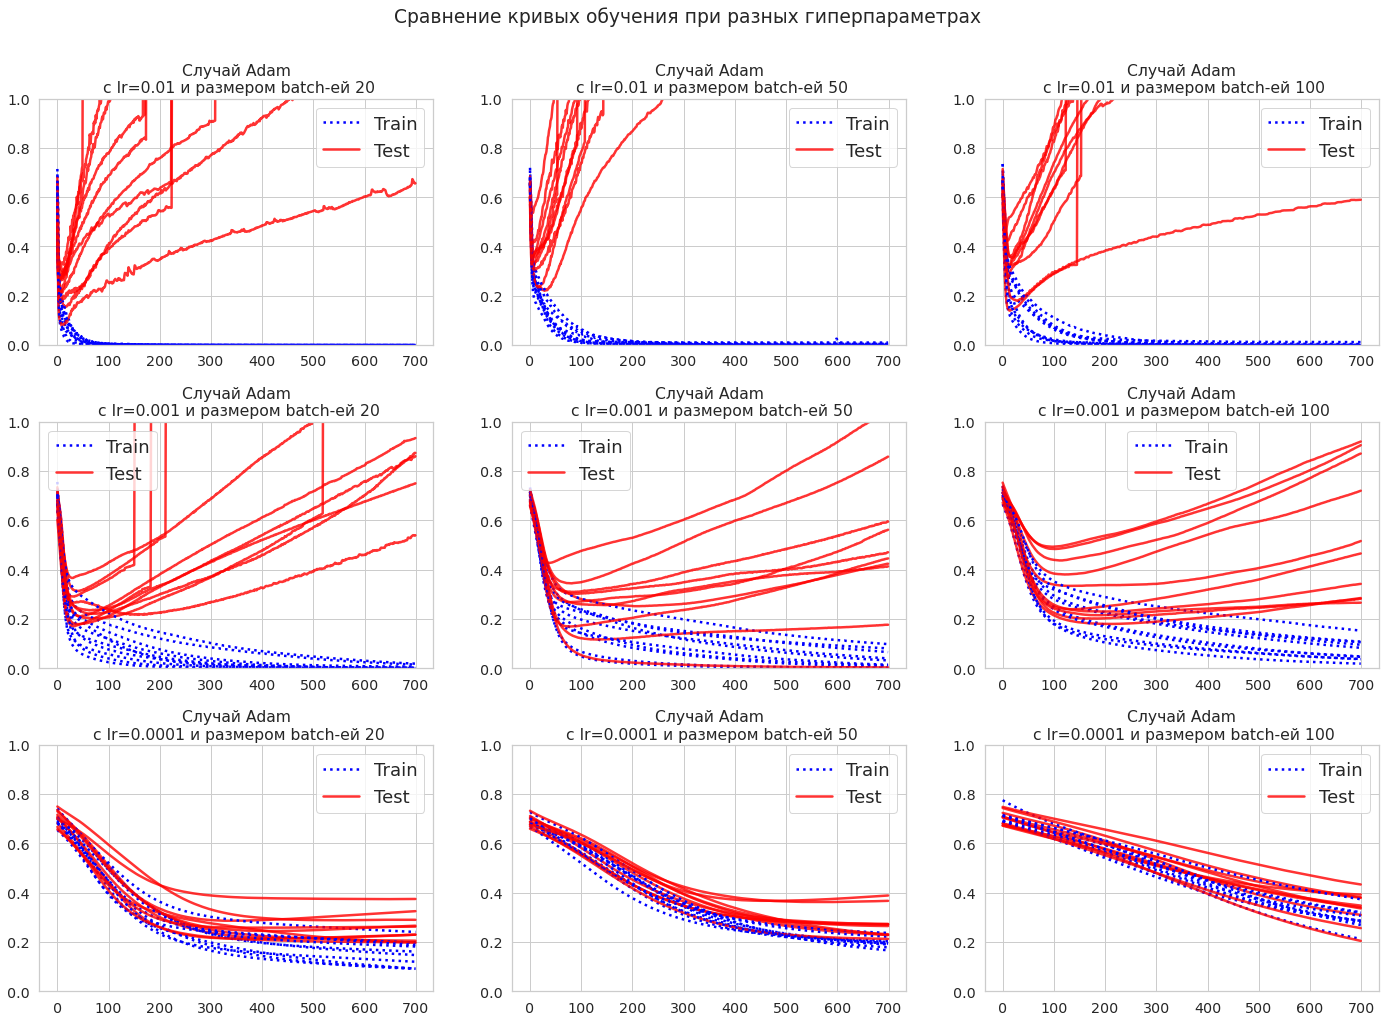

In [ ]:
test_optimizer(
    optim.Adam,
    lr=[1e-2, 1e-3, 1e-4],
    n_epochs=700,
    batch_size=[20, 50, 100],
    n_exp=10,
    train_line_fmt={'linewidth':2.5, 'color':'b', 'ls':'dotted', 'alpha':1},
    test_line_fmt={'linewidth':2.5, 'color':'r', 'alpha':0.8}
)

  0%|          | 0/14000 [00:00<?, ?it/s]

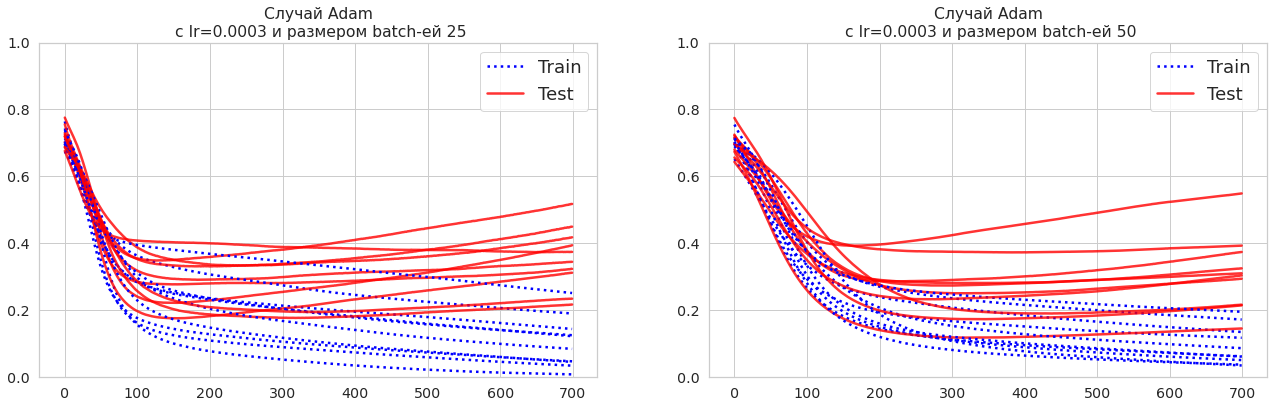

  0%|          | 0/14000 [00:00<?, ?it/s]

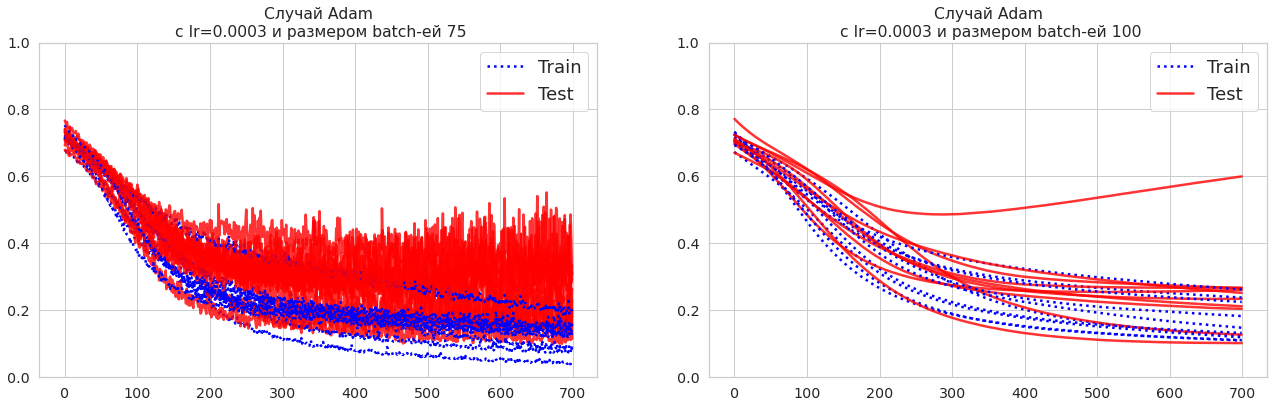

In [24]:
test_optimizer(
    optim.Adam,
    lr=3e-4,
    n_epochs=700,
    batch_size=[25, 50],
    n_exp=10,
    train_line_fmt={'linewidth':2.5, 'color':'b', 'ls':'dotted', 'alpha':1},
    test_line_fmt={'linewidth':2.5, 'color':'r', 'alpha':0.8},
    figsz=(22, 6)
)
test_optimizer(
    optim.Adam,
    lr=3e-4,
    n_epochs=700,
    batch_size=[75, 100],
    n_exp=10,
    train_line_fmt={'linewidth':2.5, 'color':'b', 'ls':'dotted', 'alpha':1},
    test_line_fmt={'linewidth':2.5, 'color':'r', 'alpha':0.8},
    figsz=(22, 6),
    clear_display=False,
)

**ВЫВОД:**

Киллер-машина Adam имеет те же проблемы с переобучением, как и RMSprop

При learning rate $10^{-4}$ и $batch\_size = 20$ в целом дает стандартный результат 0.2 - 0.4

На "правильном" lr = $3\cdot10^{-4}$ может давать в большинстве случаев $Loss \lt 0.35$ (хоть и риском переобучения), не обманули 

> Такой закрашенный график получается скорее всего из-за плохой совместимости размеров batch-a (75) и тестовой выборки (200)

### LBFGS

  0%|          | 0/36000 [00:00<?, ?it/s]

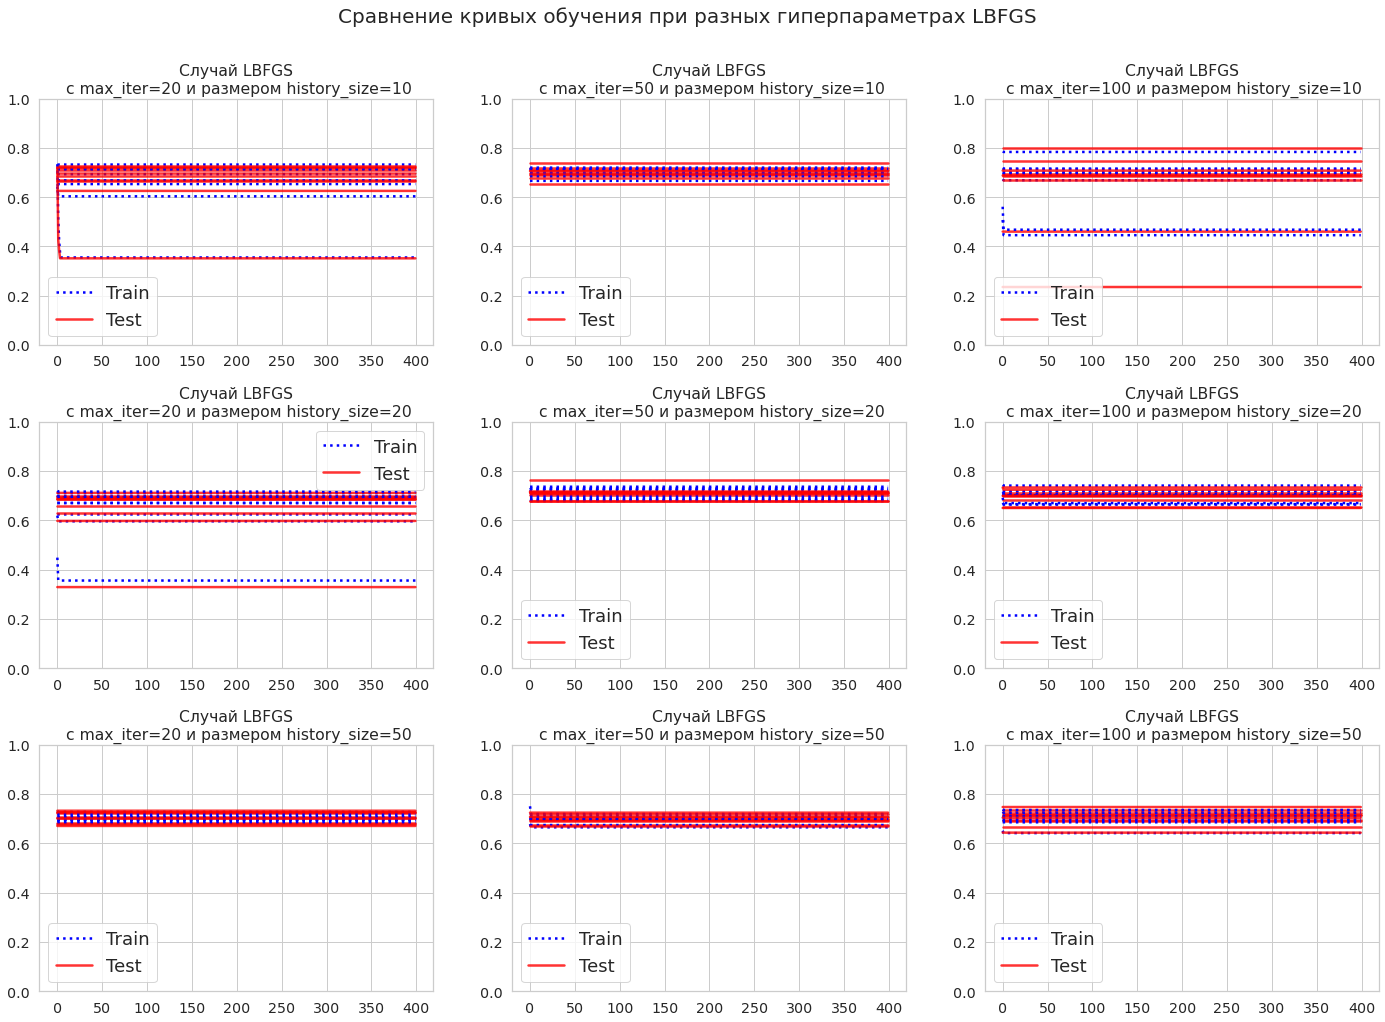

In [13]:
test_optimizer(
    optim.LBFGS,
    lr=1e-4,
    batch_size=100,
    params={'history_size':[10, 20, 50], 'max_iter':[20, 50, 100]},
    n_epochs=400,
    n_exp=10,
    train_line_fmt={'linewidth':2.5, 'color':'b', 'ls':'dotted', 'alpha':1},
    test_line_fmt={'linewidth':2.5, 'color':'r', 'alpha':0.8},
    lbfgs=True
)

  0%|          | 0/36000 [00:00<?, ?it/s]

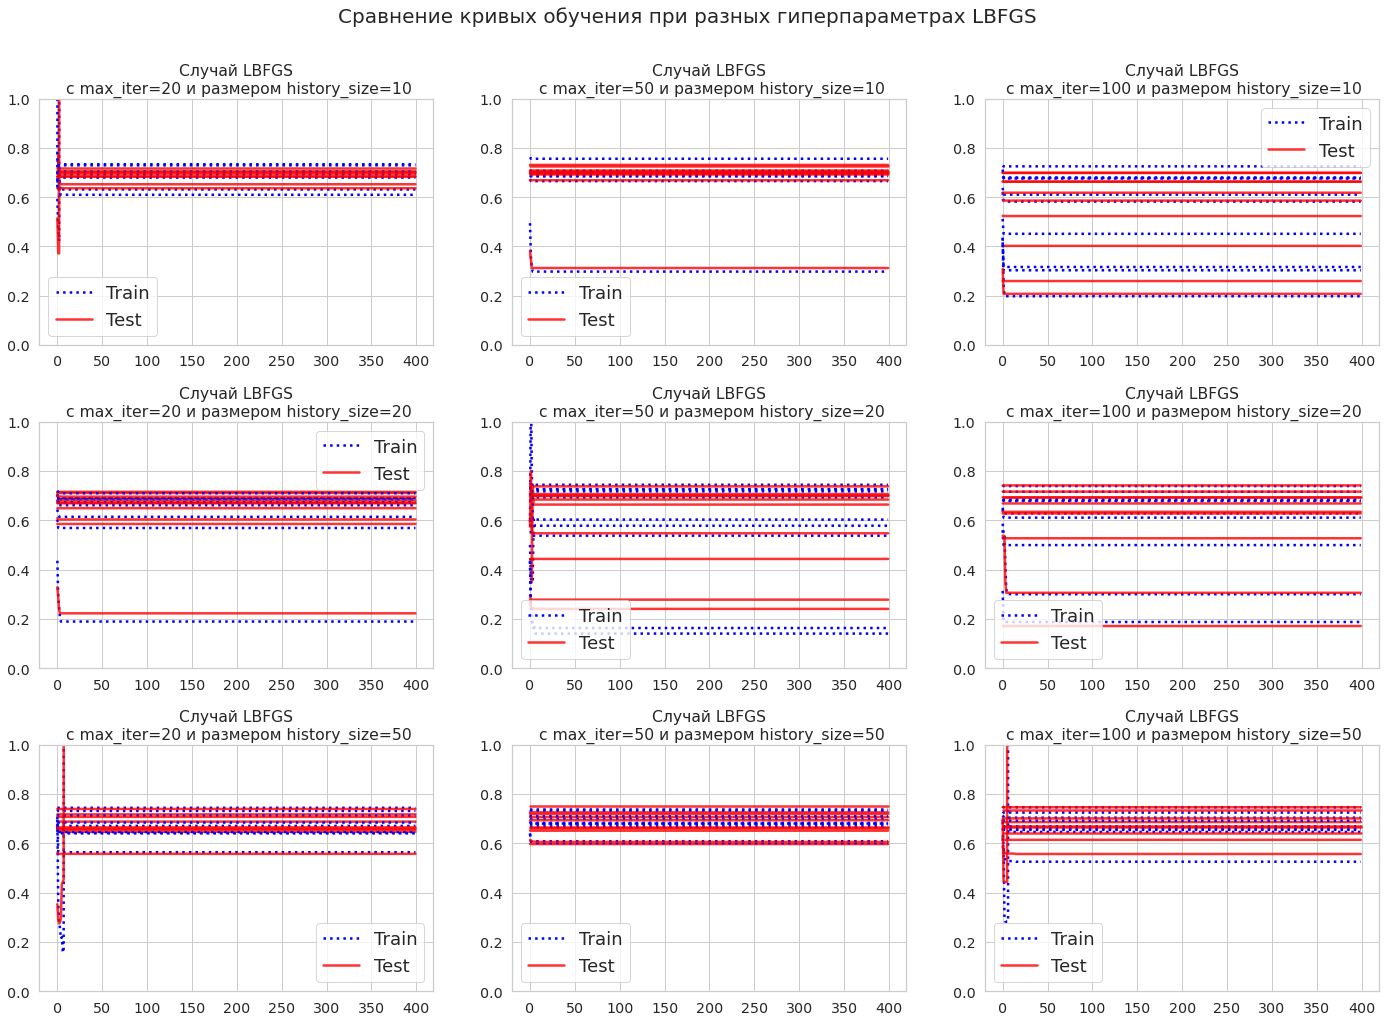

In [14]:
test_optimizer(
    optim.LBFGS,
    lr=3e-4,
    batch_size=100,
    params={'history_size':[10, 20, 50], 'max_iter':[20, 50, 100]},
    n_epochs=400,
    n_exp=10,
    train_line_fmt={'linewidth':2.5, 'color':'b', 'ls':'dotted', 'alpha':1},
    test_line_fmt={'linewidth':2.5, 'color':'r', 'alpha':0.8},
    lbfgs=True
)

  0%|          | 0/36000 [00:00<?, ?it/s]

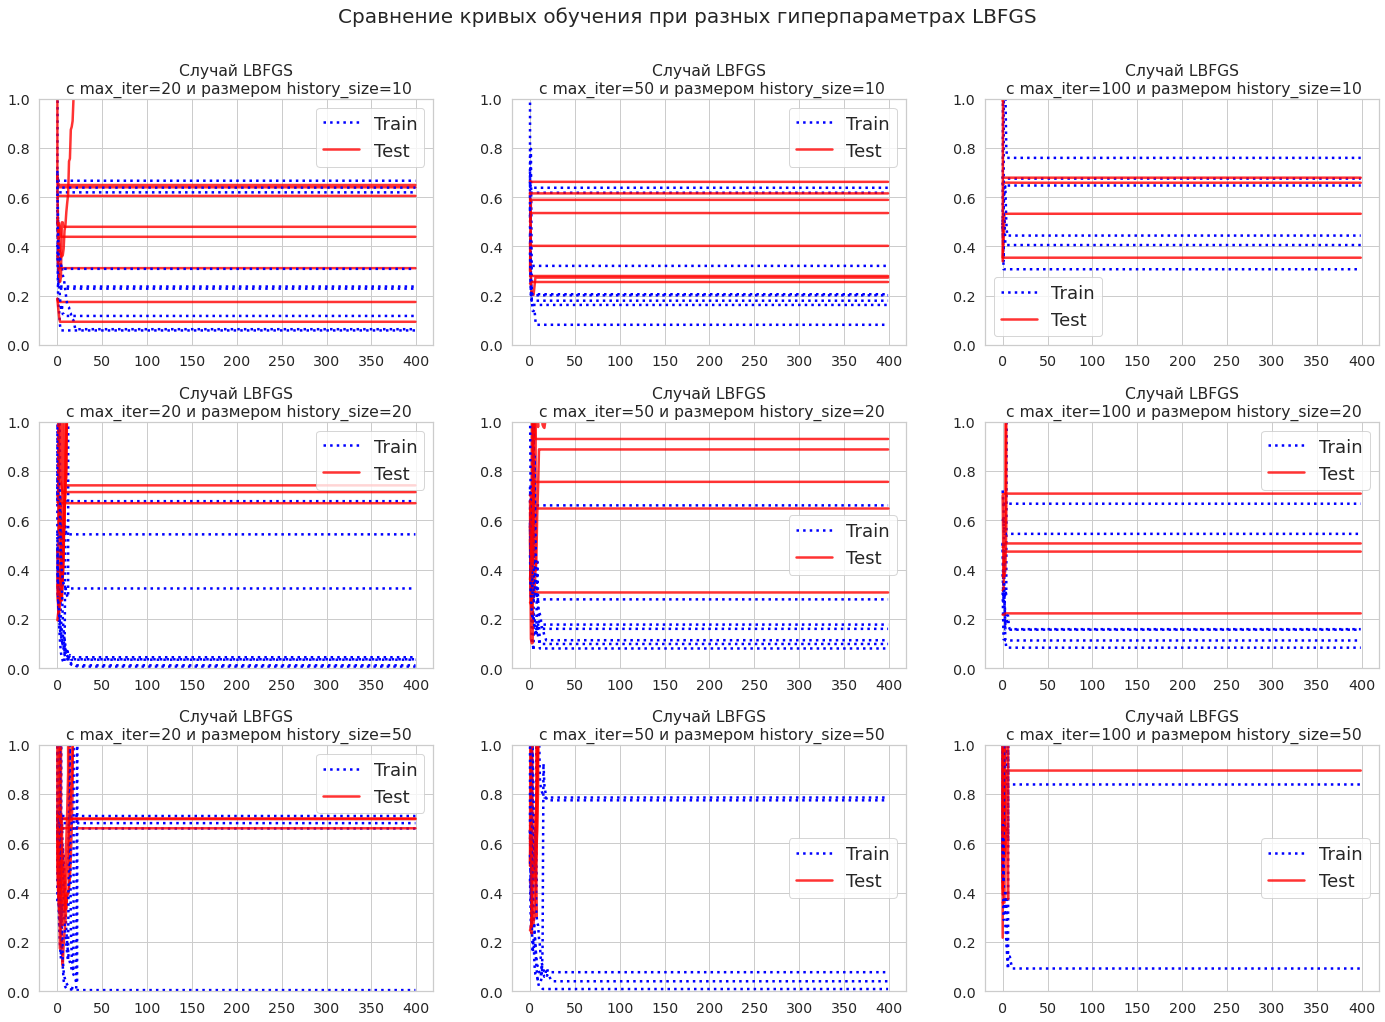

In [15]:
test_optimizer(
    optim.LBFGS,
    lr=1e-3,
    batch_size=100,
    params={'history_size':[10, 20, 50], 'max_iter':[20, 50, 100]},
    n_epochs=400,
    n_exp=10,
    train_line_fmt={'linewidth':2.5, 'color':'b', 'ls':'dotted', 'alpha':1},
    test_line_fmt={'linewidth':2.5, 'color':'r', 'alpha':0.8},
    lbfgs=True
)

**ВЫВОД:**

LBFGS упорно не хочет заводится в этом случае. Есть несколько гипотез, почему это происходит

 - Это связано с тем, что он в этой задаче плохо применим
 - Метод слишком чувствительный, и нужно очень дотошно подбирать гиперпараметры
 - Метод слишком сильно зависит от рандома

Скорее всего, проблема даже в 2 или всех сразу причинах. С завидной регулярностью метод выкидывает точность loss больше единицы, умудряясь, по сути, очень сильно косячить

 Как видно, что-то он конечно, может, но

 - Хоть каких-то результатов от него добиться получилось еле-еле
 - На графике показана только часть с $y \in [0, 1]$ и не видно, в скольких случах он считает loss порядка 10-100 и не учится совсем

Бесполезный в данном случае метод, хоть и отлично применимый для, например, ```Logistic/Linear Regression```

## Результаты

1. Параметры у всех методов индивидуалы, каждому нужно подбирать правильные гиперпараметры, чтобы он показывал себя лучше всего

2. Быстро сходится $\neq$ молодец. Быстро сходящиеся методы быстро же и переобучают модели, поэтому нужно грамотно подбирать гиперпараметры, число эпох и т.д., находя баланс между скоростью сходимости и отсутствием переобучения

> Возможно, имеет смысл как-то поддерживать приемлемый уровень разницы loss-а между train и test выборками, чтобы понимать, когда стоит остановиться, вместо тупо перебирания нужного количества epoch

3. Не все методы одинаково применимы. В то время, как обычная SGD и SGD-Momentum сошлись не сильно хуже других методов и того же Адама, показавшего лучший результат, LBFGS не стал сходится совсем и не работал в этой задаче. Аналогично, другие представленные в этой задаче методы могут не подойти в других задачах